# Registration of Tungsten fibres on XCT images

This demo aims to demonstrate the use of [gVirtualXRay](http://gvirtualxray.sourceforge.net/) and mathematical optimisation to register polygon meshes onto X-ray microtomography (micro-CT) scans of a tungsten fibre. Below is an example of CT slice.
 
![The fibre.](scanned_object.png)
 
For this purpose, we are using SimpleGVXR's Python wrapper and Python packages commonly used in tomography reconstruction ([Tomopy](https://tomopy.readthedocs.io/en/latest/)), image processing ([scikit-image](https://scikit-image.org/) and [SimpleITK](https://simpleitk.org/)), computer vision ([OpenCV](https://www.opencv.org/)), and non-linear numerical optimization ([CMA-ES, Covariance Matrix Adaptation Evolution Strategy](https://github.com/CMA-ES/pycma)).

## Import packages

We need to import a few libraries (called packages in Python). We use:
 
- `copy`: duplicating images using deepcopies;
- `math`: the `floor` function;
- `os`: creating a new directory
- `glob`: retrieving file names in a directory;
- `numpy`: who doesn't use numpy?
- `imageio`: creating GIF files;
- `skimage`: comparing the reference CT slice and the simulated one, computing the Radon transform of an image, and perform a CT reconstruction using FBP and SART;
- `tomopy`: another package for CT reconstruction;
- `SimpleITK`: image processing and saving volume data;
- OpenCV (`cv2`): Hough transform and bilateral filter (an edge-preserving smoothing filter);
- `matplotlib`: plotting data;
- `cma`: non-linear numerical optimization; and
- `gvxrPython3`: simulation of X-ray images using the Beer-Lambert law on GPU.

In [2]:
import copy, math, os, glob

import numpy as np

import imageio
from skimage.transform import radon, iradon, iradon_sart
from skimage.util import compare_images

import tomopy

import SimpleITK as sitk


import cv2

import cma

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from matplotlib import cm

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#from FlyAlgorithm import *
#from lsf import *

import gvxrPython3 as gvxr

In [3]:
if not os.path.exists("Tutorial2/outputs"):
    os.makedirs("Tutorial2/outputs");
    
if not os.path.exists("Tutorial2/plots"):
    os.makedirs("Tutorial2/plots");

## Global variables

We need some global variables.

- `g_reference_CT`: The reference XCT slice;
- `g_reference_sinogram`: The Radon transform of the reference XCT slice;
- `g_pixel_spacing_in_micrometre` and `g_pixel_spacing_in_mm`: The physical distance between the centre of two successive pixel;
- `g_number_of_projections`: The total number of angles in the sinogram;
- `g_angular_span_in_degrees`: The angular span covered by the sinogram;
- `g_angular_step`: the angular step; and
- `g_theta`: The rotation angles in degrees (vertical axis of the sinogram).


In [4]:
g_pixel_spacing_in_micrometre = 1.9;
g_pixel_spacing_in_mm = g_pixel_spacing_in_micrometre * 1e-3;
g_number_of_projections = 900;
g_angular_span_in_degrees = 180.0;
g_angular_step = g_angular_span_in_degrees / g_number_of_projections;
g_theta = np.linspace(0., g_angular_span_in_degrees, g_number_of_projections, endpoint=False);

## Load the image data

Load and display the reference projections from a raw binary file, i.e. the target of the registration.

In [5]:
# Target of the registration
reference_normalised_projections = np.fromfile("Tutorial2/sino.raw", dtype=np.float32);
reference_normalised_projections.shape = [g_number_of_projections, int(reference_normalised_projections.shape[0] / g_number_of_projections)];

In [6]:
#np.savetxt("Tutorial2/outputs/reference_sinogram.txt", reference_normalised_projections);
volume = sitk.GetImageFromArray(reference_normalised_projections);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'Tutorial2/outputs/reference_normalised_projections.mha', useCompression=True);

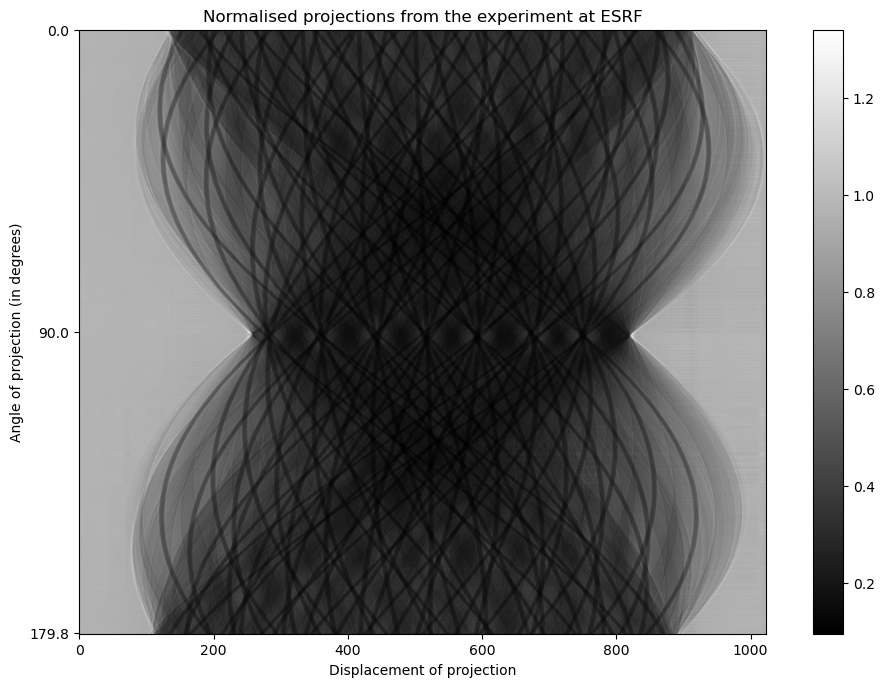

In [7]:
labels=[g_theta[0], g_theta[reference_normalised_projections.shape[0] // 2], g_theta[-1]];
tics=[0, reference_normalised_projections.shape[0] // 2, reference_normalised_projections.shape[0]-1];
fig=plt.figure();
imgplot = plt.imshow(reference_normalised_projections, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Normalised projections from the experiment at ESRF");
fig.colorbar(imgplot);
plt.savefig('Tutorial2/plots/Normalised_projections_from_experiment_ESRF.pdf')  
plt.savefig('Tutorial2/plots/Normalised_projections_from_experiment_ESRF.png')  

In the literature, a projection is often modelled as follows:

$$P = \ln\left(\frac{I_0}{I}\right) = -\ln\left(\frac{I}{I_0}\right) = \sum_n \mu(n) \Delta_x$$


`reference_normalised_projections` loaded from the binary file corresponds to $\frac{I}{I_0}$. The flat-field correction has already been performed. It is now necessary to linearise the transmission tomography data using:

$$-\ln(normalised\_projections)$$ 

This new image corresponds to the Radon transform, known as sinogram, of the scanned object in these experimental conditions. Once this is done, we divide the pixels of the sinogram by $\Delta_x$, which is egal to the spacing between two successive pixels along the horizontal axis.

We define a new function to compute the sinogram from flat-field correction and calls it straightaway.

In [8]:
def computeSinogramFromFlatField(normalised_projections):
    simulated_sinogram = -np.log(normalised_projections);
    simulated_sinogram /= g_pixel_spacing_in_micrometre * gvxr.getUnitOfLength("um") / gvxr.getUnitOfLength("cm");

    return simulated_sinogram;

In [9]:
g_reference_sinogram = computeSinogramFromFlatField(reference_normalised_projections);

In [10]:
#np.savetxt("Tutorial2/outputs/reference_sinogram.txt", g_reference_sinogram);
volume = sitk.GetImageFromArray(g_reference_sinogram);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'Tutorial2/outputs/reference_sinogram.mha', useCompression=True);

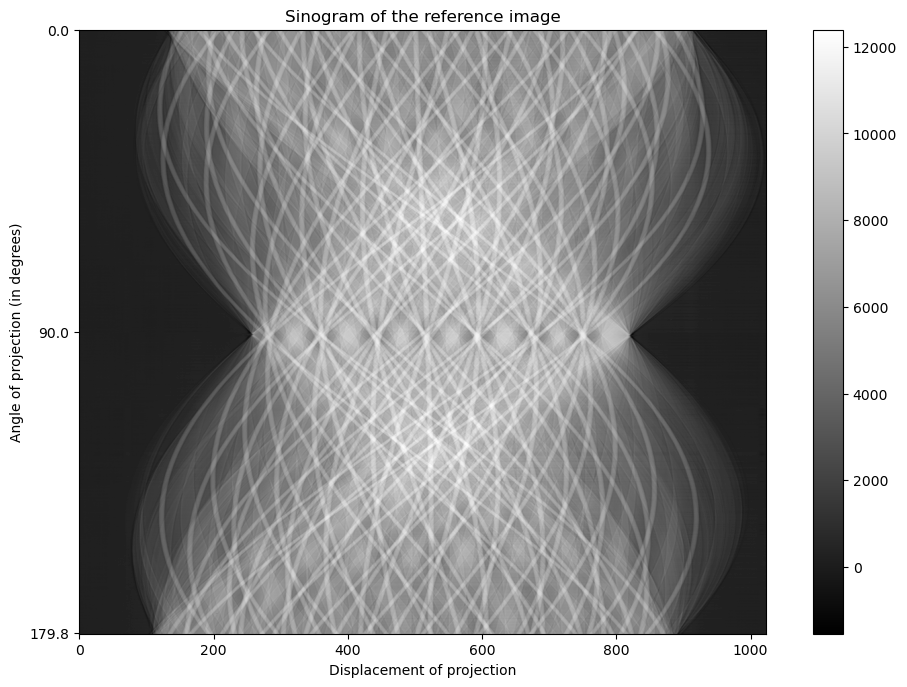

In [11]:
labels=[g_theta[0], g_theta[g_reference_sinogram.shape[0] // 2], g_theta[-1]];
tics=[0, g_reference_sinogram.shape[0] // 2, g_reference_sinogram.shape[0]-1];
fig=plt.figure();
imgplot = plt.imshow(g_reference_sinogram, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Sinogram of the reference image");
fig.colorbar(imgplot);
plt.savefig('Tutorial2/plots/Sinogram_reference_image.pdf');
plt.savefig('Tutorial2/plots/Sinogram_reference_image.png');

## CT reconstruction

Now we got a sinogram, we can reconstruct the CT slice. As we used a synchrotron, we can assume we have a parallel source. It means we can use a FBP rather than the FDK algorithm.

In [12]:
g_reference_CT = iradon(g_reference_sinogram.T, theta=g_theta, circle=True);

In [13]:
#np.savetxt("Tutorial2/outputs/reference_CT.txt", g_reference_CT);
volume = sitk.GetImageFromArray(g_reference_CT);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'Tutorial2/outputs/reference_CT.mha', useCompression=True);

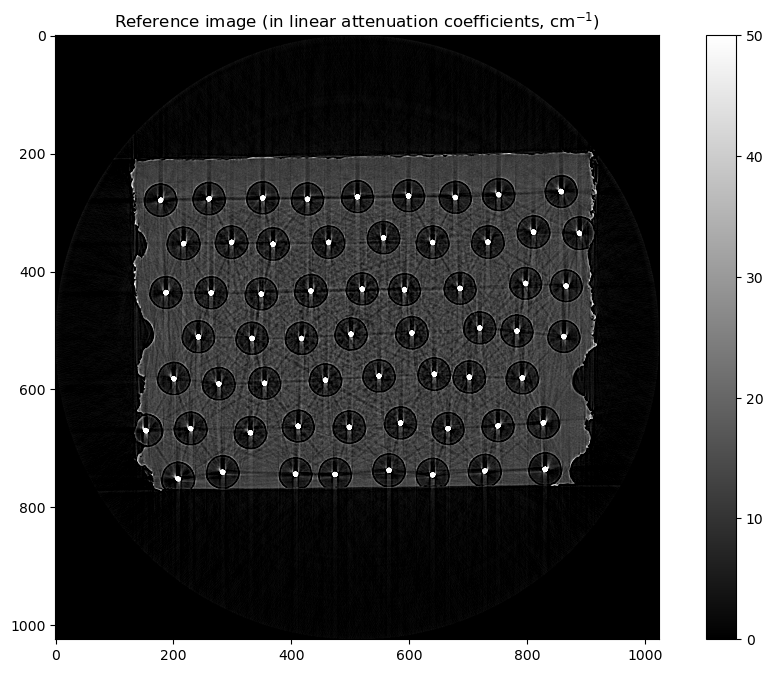

In [14]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=50, vmin=0)
imgplot = plt.imshow(g_reference_CT, cmap="gray", norm=norm);
fig.colorbar(imgplot);
plt.title("Reference image (in linear attenuation coefficients, cm$^{-1}$)");
plt.savefig('Tutorial2/plots/reference_image_in_mu.pdf');
plt.savefig('Tutorial2/plots/reference_image_in_mu.png');

## Set the X-ray simulation environment

First we create an OpenGL context, here using EGL, i.e. no window.

In [15]:
gvxr.createWindow(0, 1, "EGL");
gvxr.setWindowSize(512, 512);

We set the parameters of the X-ray detector (flat pannel), e.g. number of pixels, pixel, spacing, position and orientation:

![3D scene to be simulated using gVirtualXray](3d_scene.png)

In [16]:
detector_width_in_pixels = g_reference_sinogram.shape[1];
detector_height_in_pixels = 1;
distance_object_detector_in_m =    0.08; # = 80 mm

gvxr.setDetectorPosition(-distance_object_detector_in_m, 0.0, 0.0, "m");
gvxr.setDetectorUpVector(0, 1, 0);
gvxr.setDetectorNumberOfPixels(detector_width_in_pixels, detector_height_in_pixels);
gvxr.setDetectorPixelSize(g_pixel_spacing_in_micrometre, g_pixel_spacing_in_micrometre, "micrometer");

The beam specturm. Here we have a polychromatic beam, with 97% of the photons at 33 keV, 2% at 66 keV and 1% at 99 keV.

In [17]:
energy_spectrum = [(33, 0.97, "keV"), (66, 0.02, "keV"), (99, 0.01, "keV")];

for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

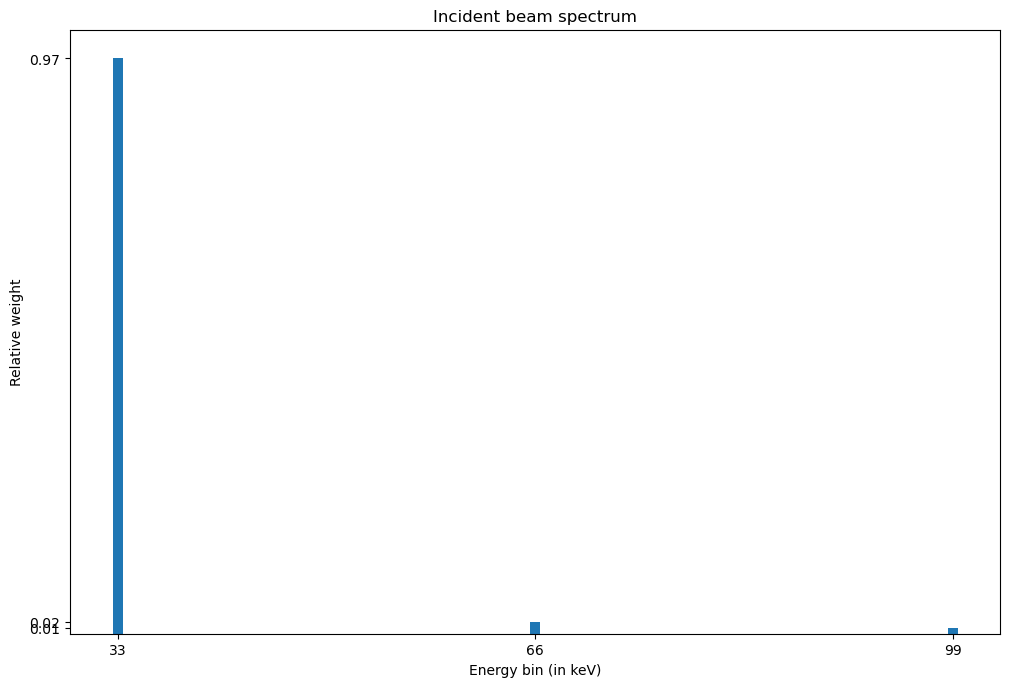

In [18]:
energies_in_keV = [];
weights = [];

for energy, percentage, unit in energy_spectrum:
    weights.append(percentage);
    energies_in_keV.append(energy * gvxr.getUnitOfEnergy(unit) / gvxr.getUnitOfEnergy("keV"));

fig=plt.figure();
plt.xlabel("Energy bin (in keV)");
plt.ylabel("Relative weight");
plt.xticks(energies_in_keV);
plt.yticks(weights);
plt.title("Incident beam spectrum");
plt.bar(energies_in_keV, weights);
plt.savefig('Tutorial2/plots/beam_spectrum.pdf');
plt.savefig('Tutorial2/plots/beam_spectrum.png');

And the source parameters (beam shape, source position)

In [19]:
# Set up the beam
distance_source_detector_in_m  = 145.0;

gvxr.setSourcePosition(distance_source_detector_in_m - distance_object_detector_in_m,  0.0, 0.0, "mm");
gvxr.usePointSource();
gvxr.useParallelBeam();

The material properties (chemical composition and density)

In [20]:
fibre_radius = 140 / 2; # um
fibre_material = [("Si", 0.5), ("C", 0.5)];
fibre_mu = 2.736; # cm-1
fibre_density = 3.2; # g/cm3

core_radius = 30 / 2; # um
core_material = [("W", 1)];
core_mu = 341.61; # cm-1
core_density = 19.3 # g/cm3

g_matrix_width = 0;
g_matrix_height = 0;
g_matrix_x = 0;
g_matrix_y = 0;
matrix_material = [("Ti", 0.9), ("Al", 0.06), ("V", 0.04)];
matrix_mu = 13.1274; # cm-1
matrix_density = 4.42 # g/cm3

## Registration of a cube

## Normalise the image data

Zero-mean unit-variance normalisation is applied to use the reference images in objective functions and perform the registration. Note that it is called standardisation (Z-score Normalisation) in machine learning. It is computed as follows:

$$I' = \frac{I - \bar{I}}{\sigma}$$

Where $I'$ is the image after the original image $I$ has been normalised, $\bar{I}$ is the average pixel value of $I$, and $\sigma$ is its standard deviation.

In [21]:
normalised_reference_sinogram = (g_reference_sinogram - g_reference_sinogram.mean()) / g_reference_sinogram.std();
normalised_reference_CT       = (g_reference_CT       - g_reference_CT.mean())       / g_reference_CT.std();

In [22]:
#np.savetxt("outputs/normalised_reference_sinogram.txt", normalised_reference_sinogram);
volume = sitk.GetImageFromArray(normalised_reference_sinogram);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/normalised_reference_sinogram.mha", useCompression=True);

#np.savetxt("outputs/normalised_reference_CT.txt", normalised_reference_CT);
volume = sitk.GetImageFromArray(normalised_reference_CT);
volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/normalised_reference_CT.mha", useCompression=True);

In [23]:
def setMatrix(apGeneSet):

    gvxr.removePolygonMeshesFromSceneGraph();

    # Matrix
    # Make a cube
    gvxr.makeCube("matrix", 1.0, "micrometer");

    # Translation vector
    x = apGeneSet[0] * detector_width_in_pixels * g_pixel_spacing_in_micrometre;
    y = apGeneSet[1] * detector_width_in_pixels * g_pixel_spacing_in_micrometre;

    gvxr.translateNode("matrix", x, 0.0, y, "micrometer");

    # Rotation angle
    rotation_angle_in_degrees = (apGeneSet[2] + 0.5) * 360.0;
    gvxr.rotateNode("matrix", rotation_angle_in_degrees, 0, 1, 0);
    
    # Scaling factors
    w = (apGeneSet[3] + 0.5) * detector_width_in_pixels * g_pixel_spacing_in_micrometre;
    h = (apGeneSet[4] + 0.5) * detector_width_in_pixels * g_pixel_spacing_in_micrometre;    
    gvxr.scaleNode("matrix", w, 815, h);

#     print("w:", w, "h:", h, "x:", x, "y:", y);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("matrix");

    # Matrix
    gvxr.setMixture("matrix", "Ti90Al6V4");
    gvxr.setDensity("matrix", matrix_density, "g/cm3");

    gvxr.addPolygonMeshAsOuterSurface("matrix");

### Simulate the CT acquisition

Compute the raw projections and save the data. For this  purpose, we define a new function.

In [24]:
def tomographyAcquisition():
    raw_projections_in_MeV = [];

    for angle_id in range(0, g_number_of_projections):
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-g_angular_step * angle_id, 0, 1, 0);
        raw_projections_in_MeV.append(gvxr.computeXRayImage());

    raw_projections_in_MeV = np.array(raw_projections_in_MeV);
    raw_projections_in_keV = raw_projections_in_MeV / gvxr.getUnitOfEnergy("keV");
    
    return raw_projections_in_keV;

### Flat-filed correction

Because the data suffers from a fixed-pattern noise in X-ray imaging in actual experiments, it is necessary to perform the flat-field correction of the raw projections using:

$$normalised\_projections = \frac{raw\_projections − dark\_field}{flat\_field\_image − dark\_field}$$

- $raw\_projections$ are the raw projections with the X-ray beam turned on and with the scanned object, 
- $flat\_field\_image$ is an image with the X-ray beam turned on but without the scanned object, and 
- $dark\_field$ is an image with the X-ray beam turned off.

Note that in our example, $raw\_projections$, $flat\_field\_image$ and $dark\_field$ are in keV whereas $normalised\_projections$ does not have any unit:

$$0 \leq raw\_projections \leq  \sum_E N_0(E) \times E\\0 \leq normalised\_projections \leq 1$$

We define a new function to compute the flat-field correction.

In [25]:
def flatFieldCorrection(raw_projections_in_keV):
    dark_field_image = np.zeros(raw_projections_in_keV.shape);
    flat_field_image = np.zeros(raw_projections_in_keV.shape);

    # Retrieve the total energy
    total_energy = 0.0;
    energy_bins = gvxr.getEnergyBins("keV");
    photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

    for energy, count in zip(energy_bins, photon_count_per_bin):
        total_energy += energy * count;
    flat_field_image = np.ones(raw_projections_in_keV.shape) * total_energy;

    normalised_projections = (raw_projections_in_keV - dark_field_image) / (flat_field_image - dark_field_image);
    
    return normalised_projections;

In [26]:
def simulateSinogram():
    raw_projections_in_keV = tomographyAcquisition();
    normalised_projections = flatFieldCorrection(raw_projections_in_keV);
    simulated_sinogram = computeSinogramFromFlatField(normalised_projections);
    
    return simulated_sinogram, normalised_projections, raw_projections_in_keV;

In [27]:
def fitnessFunction(x):
    global best_fitness, matrix_id;
    setMatrix(x);
    
    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
    normalised_simulated_sinogram = (simulated_sinogram - simulated_sinogram.mean()) / simulated_sinogram.std();

    
    # Compute the fitness function
    MAE = np.mean(np.abs(np.subtract(normalised_simulated_sinogram.flatten(), normalised_reference_sinogram.flatten())));
#     ZNCC = np.mean(np.multiply(normalised_simulated_sinogram.flatten(), normalised_reference_sinogram.flatten()));
    
    
    # Save the data
    fitness = MAE;
    if best_fitness > fitness:
        best_fitness = fitness;
        
        gvxr.saveSTLfile("matrix", "Tutorial2/outputs/matrix_" + str(matrix_id) + ".stl");
        
        # Reconstruct the CT slice
        theta = g_theta / 180.0 * math.pi;
        rot_center = int(simulated_sinogram.shape[2]/2);
        reconstruction_tomopy = tomopy.recon(simulated_sinogram, theta, center=rot_center, algorithm="gridrec", sinogram_order=False);
        normalised_simulated_CT = (reconstruction_tomopy - reconstruction_tomopy.mean()) / reconstruction_tomopy.std();
        
        MAE_CT = np.mean(np.abs(np.subtract(normalised_simulated_CT.flatten(), normalised_reference_CT.flatten())));
        ZNCC_CT = np.mean(np.multiply(normalised_simulated_CT.flatten(), normalised_reference_CT.flatten()));

        normalised_simulated_sinogram.shape = (normalised_simulated_sinogram.size // normalised_simulated_sinogram.shape[2], normalised_simulated_sinogram.shape[2]);
        volume = sitk.GetImageFromArray(normalised_simulated_sinogram);
        volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
        sitk.WriteImage(volume, "Tutorial2/outputs/normalised_simulated_sinogram_" + str(matrix_id) + ".mha", useCompression=True);

        volume = sitk.GetImageFromArray(normalised_simulated_CT);
        volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
        sitk.WriteImage(volume, "Tutorial2/outputs/normalised_simulated_CT_" + str(matrix_id) + ".mha", useCompression=True);

        np.savetxt("Tutorial2/outputs/cube_" + str(matrix_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        matrix_id += 1;
        
#     best_fitness = min(MAE, best_fitness);
        print("Best:", best_fitness, "MAE:", MAE, "ZNCC:", "%.2f" % (100*ZNCC_CT) + "%")
    
    return fitness;

In [28]:
# The registration has already been performed. Load the results.
if os.path.isfile('Tutorial2/outputs/cube.dat'):
    current_best = np.loadtxt('Tutorial2/outputs/cube.dat');
# Perform the registration using CMA-ES
else:
    best_fitness = sys.float_info.max;
    matrix_id = 0;

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-3);
    opts['tolx'] = 1e-3;
    opts['bounds'] = [5*[-0.5], 5*[0.5]];

    es = cma.CMAEvolutionStrategy(5 * [0], 0.5, opts);
    es.optimize(fitnessFunction);
    
    current_best = copy.deepcopy(es.result.xbest); # [-0.12174177  0.07941929 -0.3949529  -0.18708068 -0.23998638]
    np.savetxt("Tutorial2/outputs/cube.dat", current_best, header='x,y,rotation_angle,w,h');

### Apply the result of the registration

In [29]:
# Save the result    
setMatrix(current_best);
gvxr.saveSTLfile("matrix", "Tutorial2/outputs/matrix.stl");

### Display the result of the registration as an animation

In [30]:
def createAnimation(aPrefix, anOutputFile):
    # Find all the images from the output directory
    files = sorted(
        glob.glob(aPrefix + "[0-9]*.mha"))

    # Store the images
    registration_image_set = [];

    # Create the GIF file
    with imageio.get_writer(anOutputFile, mode='I') as writer:

        # Store the PNG filenames
        png_filename_set = [];

        # Process all the images
        for i in range(len(files)):

            # Create the filenames
            mha_fname = aPrefix + str(i) + ".mha";
            png_filename_set.append(aPrefix + str(i) + ".png");

            # Open the MHA file
            float_image = sitk.ReadImage(mha_fname);

            # Convert in a Numpy array
            narray = sitk.GetArrayFromImage(float_image)[0];
            registration_image_set.append(narray);

            # Create the figure
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            # Dispay the reference, registration and error map
            fig.suptitle('Registration: Result ' + str(i+1) + "/" + str(len(files)))
            plt.tight_layout();
            norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

            # Reference
            ax1.set_title("Reference image");
            imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                                 norm=norm);

            # Registration
            ax2.set_title("Simulated CT slice after automatic registration");
            imgplot2 = ax2.imshow(narray,
                                 cmap='gray',
                                 norm=norm);

            # Error map
            ax3.set_title("Error map (ZNCC=" + str(round(100*np.mean(np.multiply(narray, normalised_reference_CT)))) + "%)");
            imgplot3 = ax3.imshow(np.abs(narray - normalised_reference_CT),
                                 cmap='gray',
                                 norm=norm);

            # Save the figure as a PNG file
            plt.savefig(png_filename_set[i])

            # Close the figure
            plt.close()

            # Open the PNG file with imageio and add it to the GIF file
            image = imageio.imread(png_filename_set[i])
            writer.append_data(image)

            # Delete the PNG file
            os.remove(png_filename_set[i]);
            
    return registration_image_set;

In [31]:
cube_registration_image_set = createAnimation("Tutorial2/outputs/normalised_simulated_CT_",
                'Tutorial2/outputs/cube_registration.gif');

![Animation of the registration (GIF file)](Tutorial2/outputs/cube_registration.gif)

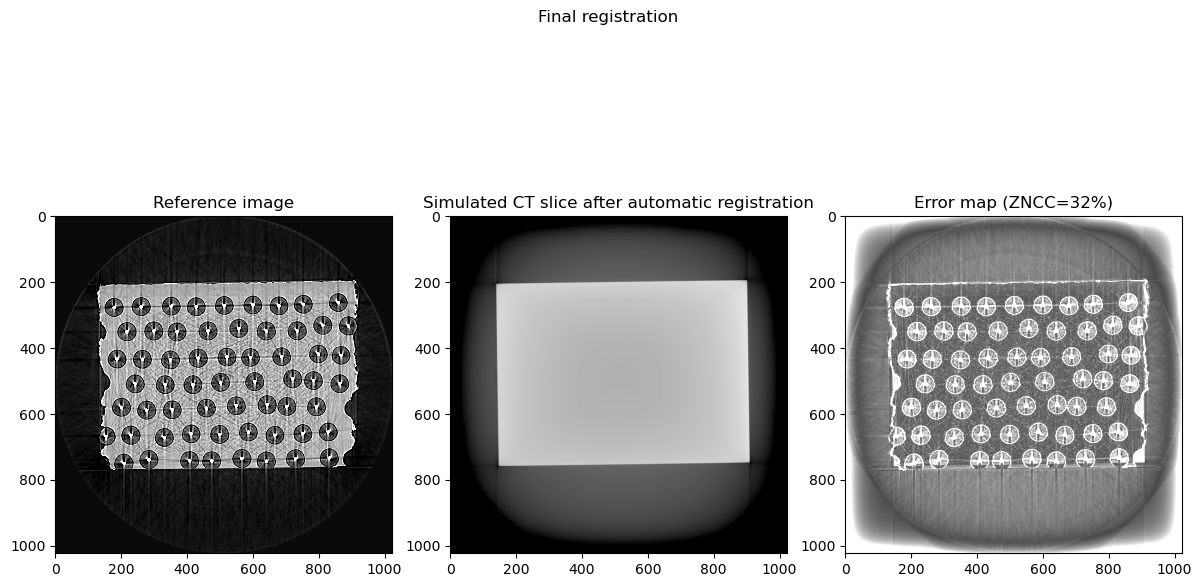

In [32]:
norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('Final registration')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(cube_registration_image_set[-1],
                     cmap='gray',
                     norm=norm);

ax3.set_title("Error map (ZNCC=" + str(round(100*np.mean(np.multiply(cube_registration_image_set[-1], normalised_reference_CT)))) + "%)");
imgplot3 = ax3.imshow(np.abs(cube_registration_image_set[-1] - normalised_reference_CT),
                     cmap='gray',
                     norm=norm);

plt.savefig('Tutorial2/plots/cube_registration.pdf');
plt.savefig('Tutorial2/plots/cube_registration.png');

## Find circles

We can use the Hoguh transform to detect where circles are in the image. However, the input image in OpenCV's function must be in UINT8. We blur it using a bilateral filter (an edge-preserving smoothing filter).

### Convert the image to UINT8

We first create a function to convert images in floating point numbers into UINT8.

In [33]:
def float2uint8(anImage):
    uchar_image = copy.deepcopy(anImage);
    uchar_image -= np.min(uchar_image);
    uchar_image /= np.max(uchar_image);
    uchar_image *= 255;
    return uchar_image.astype(np.uint8);

We blur the CT scan using a bilateral filter. It preserves edges.

In [34]:
uint8_reference_CT = float2uint8(g_reference_CT);
blurred_reference_CT = cv2.bilateralFilter(uint8_reference_CT, 9, 75, 75);
#np.savetxt("Tutorial2/outputs/blurred_reference_CT.txt", blurred_reference_CT);
volume = sitk.GetImageFromArray(blurred_reference_CT);
volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/blurred_reference_CT.mha", useCompression=True);

### Apply the Hough transform

In [35]:
circles = cv2.HoughCircles(blurred_reference_CT, cv2.HOUGH_GRADIENT, 2, 80,
                            param1=150, param2=5, minRadius=5, maxRadius=15);

### Overlay the detected circles on the top of the image

In [36]:
cimg = cv2.cvtColor(blurred_reference_CT, cv2.COLOR_GRAY2BGR);
circles = np.uint16(np.around(circles));

for i in circles[0,:]:
    
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2);
    
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3);

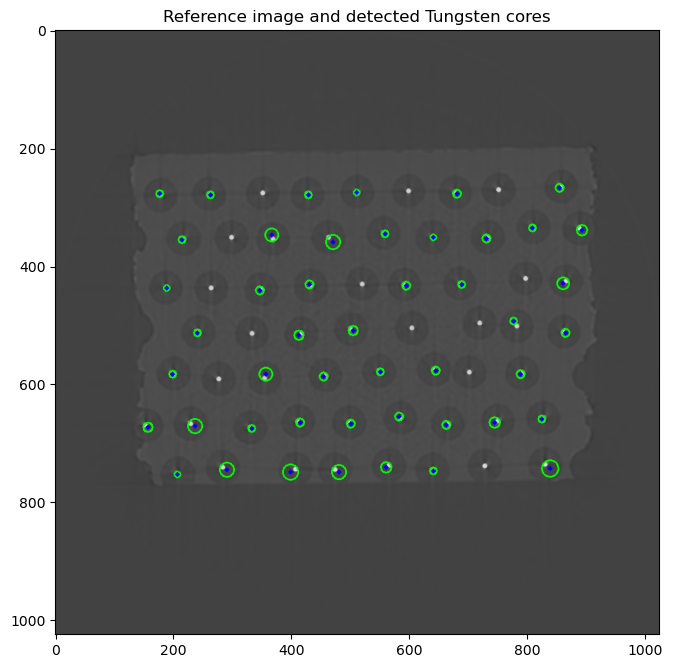

In [37]:
fig=plt.figure();
imgplot = plt.imshow(cimg);
plt.title("Reference image and detected Tungsten cores");
plt.savefig('Tutorial2/plots/fibre_detection_using_Hough_transform.pdf');
plt.savefig('Tutorial2/plots/fibre_detection_using_Hough_transform.png');

Unlike the previous example, did did not work that well. Here 13 fibres were missed. Many centres are also misplaced. We will use another technique to register the fibres. We will try another technique, the popular Otsu's method. It creates a histogram and use a heuristic to determine a threshold value.

In [38]:
# Convert in UINT8 and into a SITK image
volume = sitk.GetImageFromArray(float2uint8(g_reference_CT));
volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);

# Apply the Otsu's method
otsu_filter = sitk.OtsuThresholdImageFilter();
otsu_filter.SetInsideValue(0);
otsu_filter.SetOutsideValue(1);
seg = otsu_filter.Execute(volume);

# Print the corresponding threshold
print("Threshold:", otsu_filter.GetThreshold());

Threshold: 139.0


In [39]:
sitk.WriteImage(seg, "Tutorial2/outputs/cores_segmentation.mha", useCompression=True);

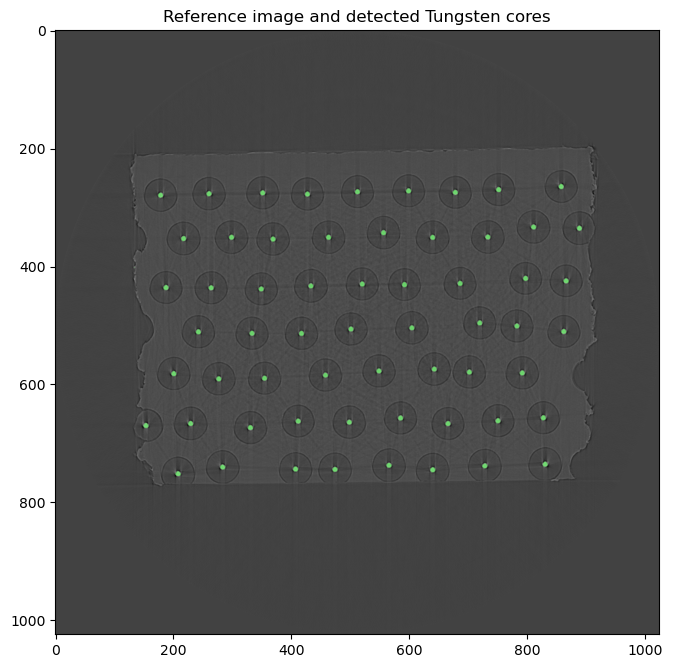

In [40]:
fig=plt.figure();
imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, seg)));
plt.title("Reference image and detected Tungsten cores");
plt.savefig('Tutorial2/plots/fibre_detection_using_otsu_method.pdf');
plt.savefig('Tutorial2/plots/fibre_detection_using_otsu_method.png');

### Clean up

In [41]:
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(seg, [3, 3, 3])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [3, 3, 3])

In [42]:
sitk.WriteImage(cleaned_thresh_img, "Tutorial2/outputs/cores_cleaned_segmentation.mha", useCompression=True);

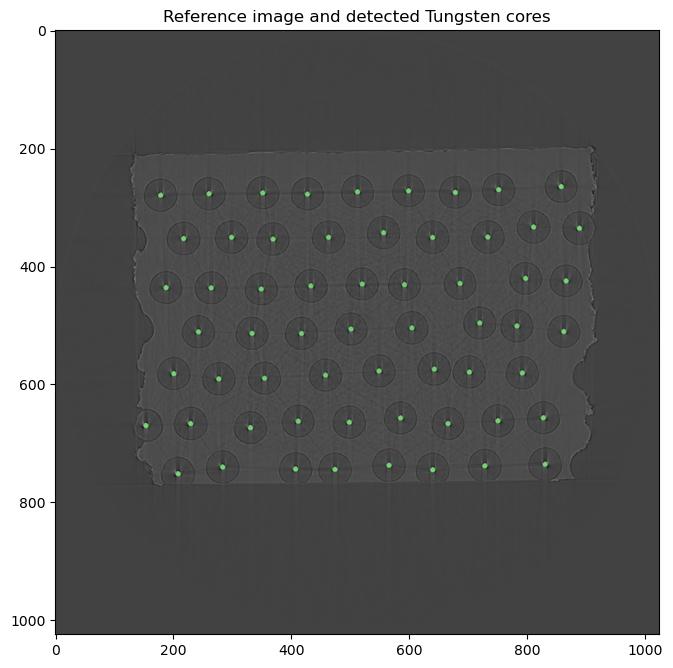

In [43]:
fig=plt.figure();
imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, cleaned_thresh_img)));
plt.title("Reference image and detected Tungsten cores");
plt.savefig('Tutorial2/plots/fibre_detection_using_otsu_method_after_cleaning.pdf');
plt.savefig('Tutorial2/plots/fibre_detection_using_otsu_method_after_cleaning.png');

### Size of objects


The radius of a tungsten core is 30 / 2 um. The pixel spacing is 1.9 um. The radius in number of pixels is $15/1.9  \approx  7.89$. The area of a core is $(15/1.9)^2  \pi  \approx 196$ pixels.

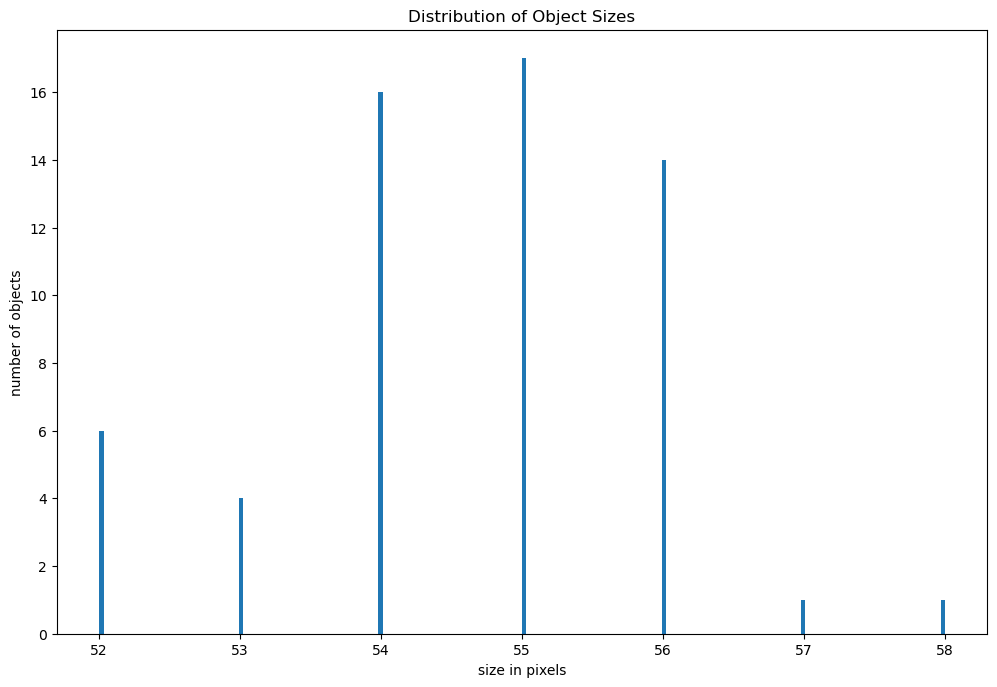

In [44]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(cleaned_thresh_img))

# Look at the distribution of sizes of connected components (bacteria).
label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

plt.figure()
plt.hist(label_sizes,bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.savefig('Tutorial2/plots/distribution_of_core_sizes.pdf');
plt.savefig('Tutorial2/plots/distribution_of_core_sizes.png');

## Mark each potential tungsten corewith unique label

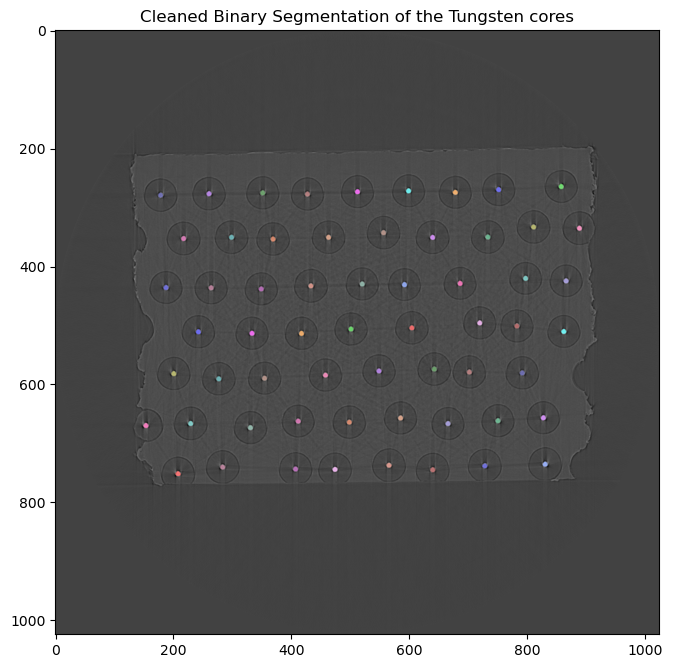

In [45]:
fig=plt.figure();
imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, sitk.ConnectedComponent(cleaned_thresh_img))));
plt.title("Cleaned Binary Segmentation of the Tungsten cores");
plt.savefig('Tutorial2/plots/fibre_detection_with_label_overlay.pdf');
plt.savefig('Tutorial2/plots/fibre_detection_with_label_overlay.png');

### Object Analysis

Once we have the segmented objects we look at their shapes and the intensity distributions inside the objects. Note that sizes are in millimetres.

In [46]:
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(sitk.ConnectedComponent(cleaned_thresh_img))

intensity_stats = sitk.LabelIntensityStatisticsImageFilter()
intensity_stats.Execute(sitk.ConnectedComponent(cleaned_thresh_img), volume) 

In [47]:
centroid_set = [];

for i in shape_stats.GetLabels():
    centroid_set.append(cleaned_thresh_img.TransformPhysicalPointToIndex(shape_stats.GetCentroid(i)));

In [48]:
def setFibres(aCentroidSet):
    
    global core_radius;
    global fibre_radius;
    
    # Add the geometries
    gvxr.emptyMesh("fibre");
    gvxr.emptyMesh("core");

    number_of_sectors = 100;

    fibre_centre = [0, 0];

    for i, cyl in enumerate(aCentroidSet):

        x = g_pixel_spacing_in_micrometre * -(cyl[0] - g_reference_CT.shape[1] / 2 + 0.5);
        y = g_pixel_spacing_in_micrometre * (cyl[1] - g_reference_CT.shape[0] / 2 + 0.5);

        fibre_centre[0] += x;
        fibre_centre[1] += y;

        gvxr.emptyMesh("fibre_" + str(i));
        gvxr.emptyMesh("core_"  + str(i));

        gvxr.makeCylinder("fibre_" + str(i), number_of_sectors, 815.0, fibre_radius, "micrometer");
        gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");

        gvxr.translateNode("fibre_" + str(i), y, 0.0, x, "micrometer");
        gvxr.translateNode("core_"  + str(i), y, 0.0, x, "micrometer");

        gvxr.subtractMesh("fibre_" + str(i), "core_" + str(i));

        gvxr.applyCurrentLocalTransformation("fibre_" + str(i));
        gvxr.applyCurrentLocalTransformation("core_" + str(i));

        #gvxr.saveSTLfile("fibre_" + str(i), "Tutorial2/outputs/fibre_" + str(i) + ".stl");
        #gvxr.saveSTLfile("core_" + str(i),  "Tutorial2/outputs/core_"  + str(i) + ".stl");

        gvxr.addMesh("fibre", "fibre_" + str(i));
        gvxr.addMesh("core",  "core_"  + str(i));

    fibre_centre[0] /= len(aCentroidSet);
    fibre_centre[1] /= len(aCentroidSet);

    gvxr.setColor("fibre", 1.0, 0.0, 0.0, 1.0);
    gvxr.setColor("core",  1.0, 0.0, 1.0, 1.0);

    #gvxr.setLinearAttenuationCoefficient("fibre", fibre_mu, "cm-1");
    gvxr.setCompound("fibre", "SiC");
    gvxr.setDensity("fibre", fibre_density, "g/cm3");

    #gvxr.setLinearAttenuationCoefficient("core", core_mu, "cm-1");
    gvxr.setElement("core", "W");

    gvxr.addPolygonMeshAsInnerSurface("core");
    gvxr.addPolygonMeshAsInnerSurface("fibre");

In [49]:
setMatrix(current_best);
setFibres(centroid_set);

In [50]:
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

In [51]:
# reconstruct the CT slice
theta = g_theta / 180.0 * math.pi;
rot_center = int(simulated_sinogram.shape[2]/2);
reconstruction_tomopy = tomopy.recon(simulated_sinogram, theta, center=rot_center, algorithm="gridrec", sinogram_order=False);
normalised_simulated_CT_with_fibres = (reconstruction_tomopy - reconstruction_tomopy.mean()) / reconstruction_tomopy.std();

In [52]:
simulated_sinogram.shape     = (simulated_sinogram.size     // simulated_sinogram.shape[2],     simulated_sinogram.shape[2]);
normalised_projections.shape = (normalised_projections.size // normalised_projections.shape[2], normalised_projections.shape[2]);
raw_projections_in_keV.shape = (raw_projections_in_keV.size // raw_projections_in_keV.shape[2], raw_projections_in_keV.shape[2]);

volume = sitk.GetImageFromArray(simulated_sinogram);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/simulated_sinogram_with_fibres.mha", useCompression=True);

volume = sitk.GetImageFromArray(normalised_projections);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/normalised_projections_with_fibres.mha", useCompression=True);

volume = sitk.GetImageFromArray(raw_projections_in_keV);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/raw_projections_in_keV_with_fibres.mha", useCompression=True);

In [53]:
volume = sitk.GetImageFromArray(reconstruction_tomopy);
volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/simulated_CT_with_fibres.mha", useCompression=True);

volume = sitk.GetImageFromArray(normalised_simulated_CT_with_fibres);
volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/normalised_simulated_CT_with_fibres.mha", useCompression=True);

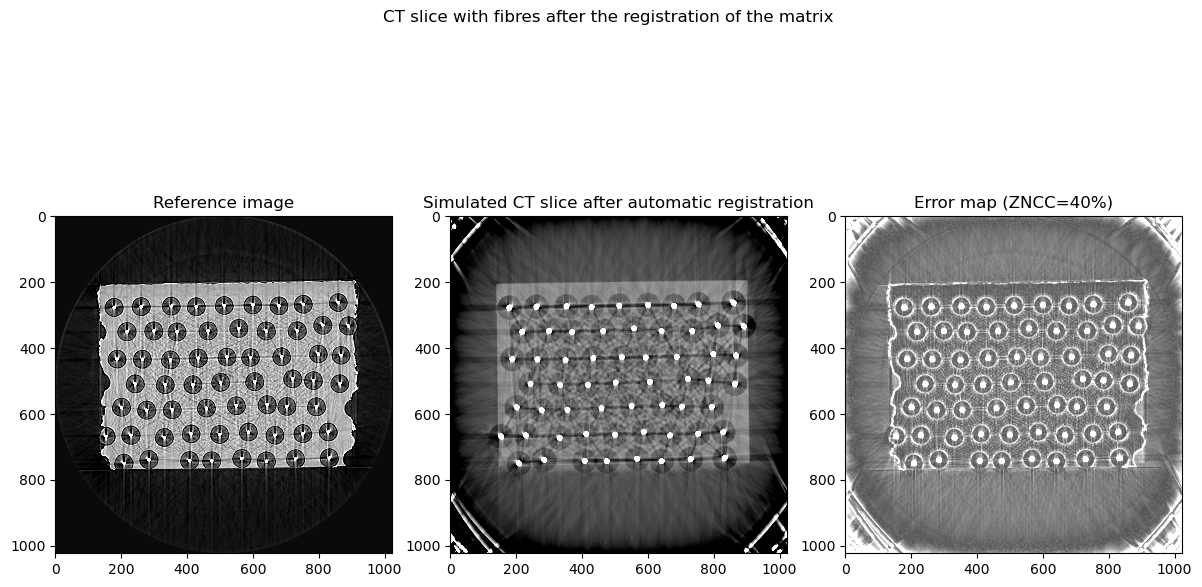

In [54]:
norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('CT slice with fibres after the registration of the matrix')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(normalised_simulated_CT_with_fibres[0],
                     cmap='gray',
                     norm=norm);

ax3.set_title("Error map (ZNCC=" + str(round(100*np.mean(np.multiply(normalised_simulated_CT_with_fibres[0], normalised_reference_CT)))) + "%)");
imgplot3 = ax3.imshow(np.abs(normalised_simulated_CT_with_fibres[0] - normalised_reference_CT),
                     cmap='gray',
                     norm=norm);
plt.savefig('Tutorial2/plots/simulated_CT_slice_with_fibres_after_cube_registration.pdf');
plt.savefig('Tutorial2/plots/simulated_CT_slice_with_fibres_after_cube_registration.png');


### Optimise fibre radius

In [56]:
def fitnessFunction(x):
    global best_fitness;
    global radius_fibre_id;
    global fibre_radius;
    global core_radius;

    # Get the radii
    fibre_radius = x[0];
    core_radius = fibre_radius * x[1];

    # Load the matrix
    setMatrix(current_best);
    
    # Load the cores and fibres
    setFibres(centroid_set);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
    normalised_simulated_sinogram = (simulated_sinogram - simulated_sinogram.mean()) / simulated_sinogram.std();

    # Reconstruct the corresponding CT slice
    theta = g_theta / 180.0 * math.pi;
    rot_center = int(simulated_sinogram.shape[2]/2);
    reconstruction_tomopy = tomopy.recon(simulated_sinogram, theta, center=rot_center, algorithm="gridrec", sinogram_order=False);
    normalised_simulated_CT = (reconstruction_tomopy - reconstruction_tomopy.mean()) / reconstruction_tomopy.std();
    
    # Compute the fitness function
    MAE_CT = np.mean(np.abs(normalised_simulated_CT.flatten() - normalised_reference_CT.flatten()));
    ZNCC_CT = np.mean(np.multiply(normalised_simulated_CT.flatten(), normalised_reference_CT.flatten()));
    
    MAE = np.mean(np.abs(normalised_simulated_sinogram.flatten() - normalised_reference_sinogram.flatten()));
    ZNCC = np.mean(np.multiply(normalised_simulated_sinogram.flatten(), normalised_reference_sinogram.flatten()));

    # Save the data
    fitness = MAE_CT;
    if best_fitness > fitness:
        best_fitness = fitness;

        volume = sitk.GetImageFromArray(normalised_simulated_CT);
        volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
        sitk.WriteImage(volume, "Tutorial2/outputs/normalised_simulated_CT_radius_fibre_" + str(radius_fibre_id) + ".mha", useCompression=True);

        normalised_simulated_sinogram.shape = (normalised_simulated_sinogram.size // normalised_simulated_sinogram.shape[2], normalised_simulated_sinogram.shape[2]);
        volume = sitk.GetImageFromArray(normalised_simulated_sinogram);
        volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
        sitk.WriteImage(volume, "Tutorial2/outputs/normalised_simulated_sinogram_radius_fibre_" + str(radius_fibre_id) + ".mha", useCompression=True);

        np.savetxt("Tutorial2/outputs/fibre_radius_" + str(radius_fibre_id) + ".dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');
            
        radius_fibre_id += 1;
        
        print("Best:", best_fitness, "MAE:", MAE, "ZNCC:", "%.2f" % (100*ZNCC_CT) + "%")
    
    return fitness;

In [60]:
# The registration has already been performed. Load the results.
if os.path.isfile('Tutorial2/outputs/fibre_radius.dat'):
    temp = np.loadtxt('Tutorial2/outputs/fibre_radius.dat');
    core_radius = temp[0];
    fibre_radius = temp[1];
# Perform the registration using CMA-ES
else:
    # An individual is made of two floating point numbers:
    # - the radius of the SiC fibre
    # - the ratio    radius of the W core / radius of the SiC fibre
    
    fibre_radius = 140 / 2; # um
    core_radius = 30 / 2; # um
    ratio = core_radius / fibre_radius;
    
    x0 = [fibre_radius, ratio];
    bounds = [[5, 0.01], [1.5 * fibre_radius, 0.95]];
    
    best_fitness = sys.float_info.max;
    radius_fibre_id = 0;

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-3);
    opts['tolx'] = 1e-3;
    opts['bounds'] = bounds;
    opts['seed'] = 1;
    
    es = cma.CMAEvolutionStrategy(x0, 0.9, opts);
    es.optimize(fitnessFunction);
    
    fibre_radius = es.result.xbest[0];
    core_radius = fibre_radius * es.result.xbest[1];

    np.savetxt("Tutorial2/outputs/fibre_radius.dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=1, Wed Jan 20 10:19:59 2021)
Best: 0.5698212 MAE: 0.37849738726750376 ZNCC: 33.54%
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 5.698211789131165e-01 1.0e+00 1.17e+00  1e+00  1e+00 0:11.7
Best: 0.4926364 MAE: 0.2957888733802279 ZNCC: 55.22%
    2     12 4.926364123821259e-01 1.5e+00 1.09e+00  1e+00  1e+00 0:23.6
    3     18 5.517124533653259e-01 1.5e+00 8.43e-01  7e-01  9e-01 0:36.6
    4     24 6.193422675132751e-01 1.6e+00 7.59e-01  6e-01  6e-01 0:48.6
    5     30 6.087706685066223e-01 1.3e+00 6.63e-01  5e-01  5e-01 0:60.0
    6     36 5.340964794158936e-01 1.4e+00 7.31e-01  6e-01  6e-01 1:10.8
    7     42 5.004928708076477e-01 1.3e+00 7.18e-01  5e-01  5e-01 1:21.8
Best: 0.4921685 MAE: 0.29644413530667885 ZNCC: 55.58%
    8     48 4.921684861183167e-01 1.3e+00 6.29e-01  4e-01  4e-01 1:32.9
    9     54 5.170086026191711e-01 1.2e+00 5.02e-01  3e-01  3e-01 1:43.7
Best: 0.47949398 MAE: 0.2

In [61]:
fibre_registration_image_set = createAnimation("Tutorial2/outputs/normalised_simulated_CT_radius_fibre_",
                'Tutorial2/outputs/fibre_registration.gif');

![Animation of the registration (GIF file)](Tutorial2/outputs/fibre_registration.gif)

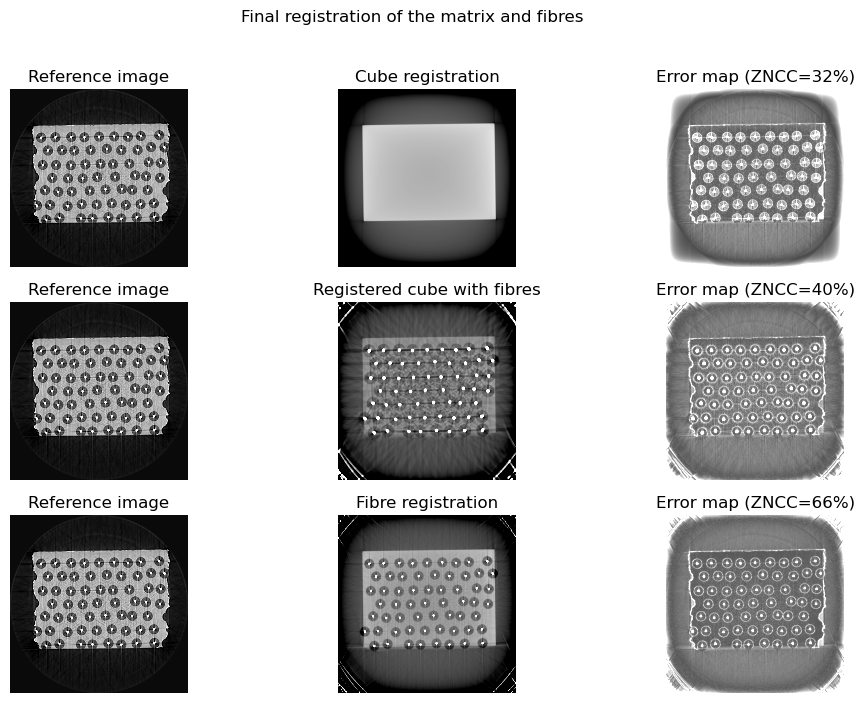

In [62]:
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)] = plt.subplots(3, 3)
# plt.tight_layout()
fig.suptitle('Final registration of the matrix and fibres')


ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);
ax1.axis('off');

ax2.set_title("Cube registration");
imgplot2 = ax2.imshow(cube_registration_image_set[-1],
                     cmap='gray',
                     norm=norm);
ax2.axis('off');

ax3.set_title("Error map (ZNCC=" + str(round(100*np.mean(np.multiply(cube_registration_image_set[-1], normalised_reference_CT)))) + "%)");
imgplot3 = ax3.imshow(np.abs(cube_registration_image_set[-1] - normalised_reference_CT),
                     cmap='gray',
                     norm=norm);
ax3.axis('off');

ax4.set_title("Reference image");
imgplot1 = ax4.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);
ax4.axis('off');

ax5.set_title("Registered cube with fibres");
imgplot2 = ax5.imshow(normalised_simulated_CT_with_fibres[0],
                     cmap='gray',
                     norm=norm);
ax5.axis('off');

ax6.set_title("Error map (ZNCC=" + str(round(100*np.mean(np.multiply(normalised_simulated_CT_with_fibres[0], normalised_reference_CT)))) + "%)");
imgplot3 = ax6.imshow(np.abs(normalised_simulated_CT_with_fibres[0] - normalised_reference_CT),
                     cmap='gray',
                     norm=norm);
ax6.axis('off');


ax7.set_title("Reference image");
imgplot1 = ax7.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);
ax7.axis('off');

ax8.set_title("Fibre registration");
imgplot2 = ax8.imshow(fibre_registration_image_set[-1],
                     cmap='gray',
                     norm=norm);
ax8.axis('off');

ax9.set_title("Error map (ZNCC=" + str(round(100*np.mean(np.multiply(fibre_registration_image_set[-1], normalised_reference_CT)))) + "%)");
imgplot3 = ax9.imshow(np.abs(fibre_registration_image_set[-1] - normalised_reference_CT),
                     cmap='gray',
                     norm=norm);
ax9.axis('off');

plt.savefig('Tutorial2/plots/simulated_CT_slice_with_cube_and_fibre_registrations.pdf');
plt.savefig('Tutorial2/plots/simulated_CT_slice_with_cube_and_fibre_registrations.png');

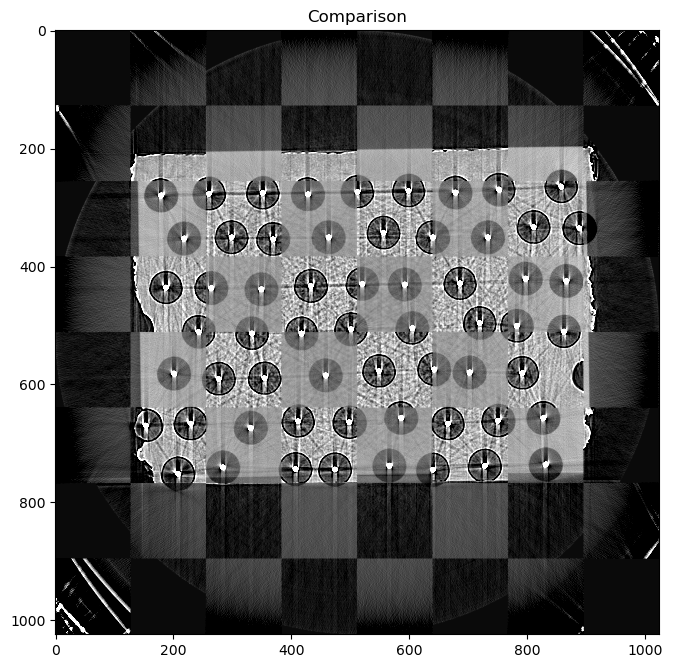

In [63]:
comp_equalized = compare_images(normalised_reference_CT, fibre_registration_image_set[-1], method='checkerboard')

fig=plt.figure();
imgplot = plt.imshow(comp_equalized, cmap='gray', norm=norm);
plt.title("Comparison");
plt.savefig('Tutorial2/plots/comparison.pdf');
plt.savefig('Tutorial2/plots/comparison.png');

### Apply the result of the registration

In [64]:
# Load the matrix
setMatrix(current_best);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "Tutorial2/outputs/fibre.stl");
gvxr.saveSTLfile("core",  "Tutorial2/outputs/core.stl");